In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!pip install fastText
import fasttext.util
fasttext.util.download_model('ar', if_exists='ignore') 

In [3]:
import fasttext.util
model = fasttext.load_model('cc.ar.300.bin')

In [149]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
import gensim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report, f1_score


#text is already cleaned.
#assign cleaned data to these variables.
train_data_path = 'cleaned_data/cleaned_train_data_for_subtask1.csv'
test_data_path = 'cleaned_data/cleaned_test_data_for_subtask1.csv'
#read files.
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

del train_data['#1_tweetid']
del train_data['#2_tweet']
del test_data['#1_tweetid']
del test_data['#2_tweet']

print("Train set:"% train_data.columns, train_data.shape, len(train_data)) 
print("Test set:"% test_data.columns, test_data.shape, len(test_data)) 



Train set: (21000, 2) 21000
Test set: (5000, 2) 5000


In [150]:
#add numerical representation.
classes = train_data['#3_country_label'].unique().tolist()
classes_dic = {}
for i, class_name in enumerate(classes):
    classes_dic[class_name] = i
display(classes_dic)

def find_class_id_from_name(class_name):
    return classes_dic[class_name]

train_data['#4class_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['#4class_id']=test_data['#3_country_label'].apply(find_class_id_from_name)

display(train_data)
display(test_data)



{'Egypt': 0,
 'Iraq': 1,
 'Saudi_Arabia': 2,
 'Mauritania': 3,
 'Algeria': 4,
 'Syria': 5,
 'Oman': 6,
 'Tunisia': 7,
 'Lebanon': 8,
 'Morocco': 9,
 'Djibouti': 10,
 'United_Arab_Emirates': 11,
 'Kuwait': 12,
 'Libya': 13,
 'Bahrain': 14,
 'Qatar': 15,
 'Yemen': 16,
 'Palestine': 17,
 'Jordan': 18,
 'Somalia': 19,
 'Sudan': 20}

,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,حاجه حلوه اكيد,0
1,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا و يغشو...,1
2,Saudi_Arabia,ابشر طال عمرك,2
3,Mauritania,منطق انا و الغريب علي ابن عمي و انا و الغريب و...,3
4,Algeria,شهرين و تروح و الباقي غير صيف ملينا,4
5,Syria,يابنتي و اله ما حد متغاظ و لا مفروس منك و لا ب...,5
6,Egypt,نفس الوقت باكد علي صاحبتي ان اي هدف هتحطه و تخ...,0
7,Egypt,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,0
8,Oman,ما يله دخل,6
9,Iraq,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه ...,1


,#3_country_label,#2_tweet_clean,#4class_id
0,Egypt,قولنا اون لاين لا ياعلي اون لاين لا,0
1,Oman,ه بايخه ه,6
2,Lebanon,ربنا يخليك يادوك و لك المثل,8
3,Syria,اوامر ملكيه ياشباب اي و احد فيكم عنده شي يذكره...,5
4,Libya,شد عالخط حتي هيا اكويسه,13
5,Egypt,انا صاحي ميت مالضحك ايه دا,0
6,Saudi_Arabia,لا مين انت ه,2
7,Palestine,جاي عبالي رشوف,17
8,Morocco,ان شاء اله تبوا الي و ابقي الكن كل العمر امين ...,9
9,Egypt,اله يلعنك انت اصلا مريض انتزعت من قلبك الرحه,0


In [151]:
#check no. of tweets for each country.
df_majority_minority = train_data.groupby(['#3_country_label','#4class_id']).size().to_frame('count').reset_index()
df_majority_minority.sort_values(by=['count'], inplace=True, ascending=False)
display(df_majority_minority)

,#3_country_label,#4class_id,count
3,Egypt,0,4283
4,Iraq,1,2729
14,Saudi_Arabia,2,2140
0,Algeria,4,1809
11,Oman,6,1501
17,Syria,5,1287
8,Libya,13,1286
18,Tunisia,7,859
10,Morocco,9,858
7,Lebanon,8,644


In [152]:
#get major country.
major_country = df_majority_minority.iloc[0]['#3_country_label']
major_samples_no = df_majority_minority.iloc[0]['count']
print("major country is", major_country ,"with: ", major_samples_no, "samples.")

major country is Egypt with:  4283 samples.


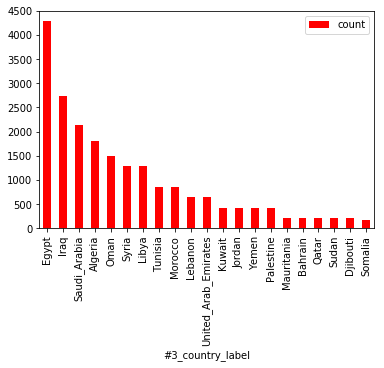

In [153]:
df_majority_minority.plot(kind='bar',x='#3_country_label',y='count',color='red')
plt.show()

In [154]:
display(train_data['#2_tweet_clean'][5])
display(test_data['#2_tweet_clean'][6])

'يابنتي و اله ما حد متغاظ و لا مفروس منك و لا بيحسدك انتي عره اساسا'

'لا مين انت ه '

In [155]:
#remove arabic formal clitics from tweets.
stop_words_file = open('formal clitics stop words.txt','r',encoding="utf8")
stop_words_list = [line.strip() for line in stop_words_file]

def remove_stopwords(text):
    text_tokens = text.strip().split(" ")
    tokens_filtered= [word for word in text_tokens if not word in stop_words_list]
    return (" ").join(tokens_filtered)

train_data['#2_tweet_clean']= train_data['#2_tweet_clean'].apply(remove_stopwords)
    
test_data['#2_tweet_clean']= test_data['#2_tweet_clean'].apply(remove_stopwords)
    
    
display(train_data['#2_tweet_clean'][5])
display(test_data['#2_tweet_clean'][6])

'يابنتي اله حد متغاظ مفروس منك بيحسدك انتي عره اساسا'

'مين انت'

In [156]:
#Using Fasttext + remove stopworrds.
import csv

#train_data['#2_tweet_clean']= train_data['#2_tweet_clean'].apply(lambda x: ' '.join(gensim.utils.simple_preprocess(x)))
#test_data['#2_tweet_clean']= test_data['#2_tweet_clean'].apply(lambda x: ' '.join(gensim.utils.simple_preprocess(x)))

# Prefixing each row of the class column with '__label__'
train_data['#4class_id'] = train_data['#4class_id'].apply(lambda x: '__label__' + str(x))
test_data['#4class_id'] = test_data['#4class_id'].apply(lambda x: '__label__' + str(x))


train_data[['#4class_id','#2_tweet_clean']].to_csv('train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")
test_data[['#4class_id','#2_tweet_clean']].to_csv('test.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")



In [173]:
# Training the fastText classifier
model = fasttext.train_supervised('train.txt', lr=1, epoch=100, wordNgrams=4)
print(len(model.words))

45934


In [183]:
y_pred = model.predict('هبل اوي')
print(y_pred)
print(model.test('test.txt'))
#print(classification_report(test_data['#4class_id'], y_pred, target_names=classes))


(('__label__0',), array([0.98532337]))
(5000, 0.3422, 0.3422)


In [179]:
#prepare train and test data.
X_train = train_data['#2_tweet_clean']
y_train = train_data['#4class_id']
X_test = test_data['#2_tweet_clean']
y_test = test_data['#4class_id']

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
display(nb)
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


In [ ]:
# tokinizing/victorizing text:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
text_embedding = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
   text_embedding[i] = nlp(word).vector

display(X_train)
#victorize/word embedding
#balance data.
#train.
#fit.
#score.

In [ ]:
#balance data.
#Oversampling the data
smote = SMOTE(random_state = 101)
X_train, y_train = smote.fit_resample(X_train, y_train) #Creating a new Oversampling Data Frame
display(y_train.shape)
display(X_train.shape)

In [ ]:
#select model.
smote = SMOTE('minority')
x_sm,y_sm = smote.fit_sample(X_train, y_train)
print(x_sm.shape,y_sm.shape)

In [ ]:
#score.
result = np.argmax(model.predict(testing_padded), axis=-1)
print(classification_report(test_data['classes_id'].astype(int).tolist(), result, target_names=classes_names))
print(f1_score(test_data['classes_id'].astype(int).tolist(), result, average='macro'))
